<a href="https://colab.research.google.com/github/tinywizzard/HAAI_Codes/blob/main/ProgAssign4_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective:** This assignment has two objectives:
1. Understanding how to implement Image Classification model using PyTorch.
2. Develop a pipeline to solve the MNIST classification problem and output model accuracy.

**Problem:** Write a Python program using the provided template to train and test a partial MNIST
dataset using a modified AlexNet as shown below. The program should accept three integers as
command line input. First two integers define the labels of the two-class classification and third integer
represents the number of epochs for training. Output only the final model accuracy and nothing else.

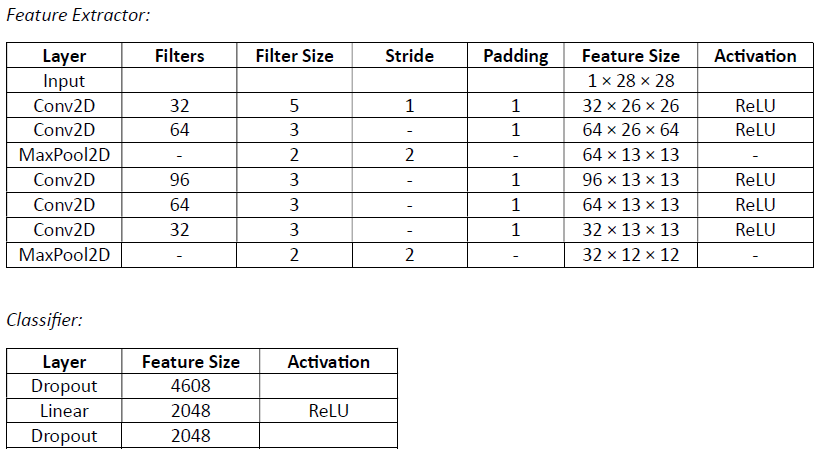
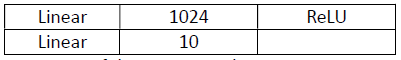

**Note:** Even if there are two classes, we output 10 features in the last Linear layer for correct mapping.
**Instructions:** Download the dataset along with template program and write your code in the
designated location mentioned in the comments only. **You are required only to write the sequential
model for feature extractor, classifier and forward (feature extractor THEN classifier). The dataset
must be in the current working directory with the structure** data/MNIST/raw/*. You should read the
skeleton code to understand the exact mechanism of input from the command line and provide the
required output. To train and test modified AlexNet with 1 and 2 MNIST classes with 4 training epochs,
the command line input should be: python assignment.py 1 2 4

**Execution Syntax:** python assignment.py \<number> \<number> \<number>

**Sample Test Cases:**

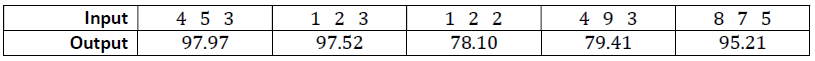

In [ ]:
# !pip install torchsummary

In [ ]:
"""
This program is a partial MNIST classifier using AlexNet. It accepts three parameters provided as a command line input. The first two inputs are two digits between 0-9 which are used to train and test the classifier and the third parameter controls the number of training epochs.
Syntax: python assignment.py <number> <number> <number>

For example, to train and test AlexNet with 1 and 2 MNIST samples with 4 training epochs, the command line input should be:
python assignment.py 1 2 4
"""

"""
ALERT: * * * No changes are allowed to import statements  * * *
"""
import sys
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary


In [ ]:
"""
* * * Changes allowed from here  * * *
"""

class AlexNet(nn.Module):
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            # Define feature extractor here...
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)       #changed stride to 1 instead of 2 to get expected outputs
        )
        self.classifier = nn.Sequential(
            # Define classifier here...
            nn.Dropout(),
            nn.Linear(32*12*12, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num)
        )

    def forward(self, x):
        # define forward network 'x' that combines feature extractor and classifier
        x = self.feature(x)
        x = x.view(-1, 32*12*12)
        x = self.classifier(x)
        return x

"""
ALERT: * * * No changes are allowed after this comment  * * *
"""

'\nALERT: * * * No changes are allowed after this comment  * * *\n'

In [ ]:
'''
ANALYZING TORCH MODEL SUMMARY
'''

model = AlexNet()

'''
ACCLERATED COMPUTING
'''

if torch.cuda.is_available():
  print('GPU is available!')
  model.cuda()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             832
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 26, 26]          18,496
              ReLU-4           [-1, 64, 26, 26]               0
         MaxPool2d-5           [-1, 64, 13, 13]               0
            Conv2d-6           [-1, 96, 13, 13]          55,392
              ReLU-7           [-1, 96, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          55,360
              ReLU-9           [-1, 64, 13, 13]               0
           Conv2d-10           [-1, 32, 13, 13]          18,464
             ReLU-11           [-1, 32, 13, 13]               0
        MaxPool2d-12           [-1, 32, 12, 12]               0
          Dropout-13                 [-1, 4608]               0
           Linear-14                 [-

In [ ]:
def load_subset(full_train_set, full_test_set, label_one, label_two):
    # Sample the correct train labels
    train_set = []
    data_lim = 20000
    for data in full_train_set:
        if data_lim>0:
            data_lim-=1
            if data[1]==label_one or data[1]==label_two:
                train_set.append(data)
        else:
            break

    test_set = []
    data_lim = 1000
    for data in full_test_set:
        if data_lim>0:
            data_lim-=1
            if data[1]==label_one or data[1]==label_two:
                test_set.append(data)
        else:
            break

    return train_set, test_set

def train(model,optimizer,train_loader,epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def test(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()#size_average=False
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    test_accuracy = (acc / len(test_loader.dataset))
    return test_accuracy

In [ ]:
if __name__ == '__main__':

    # if len(sys.argv) == 3:
    #     print("Usage: python assignment.py <number> <number>")
    #     sys.exit(1)

    input_data_one = input().strip()
    input_data_two = input().strip()
    epochs = input().strip()

    """  Call to function that will perform the computation. """
    if input_data_one.isdigit() and input_data_two.isdigit() and epochs.isdigit():

        label_one = int(input_data_one)
        label_two = int(input_data_two)
        epochs = int(epochs)

        if label_one!=label_two and 0<=label_one<=9 and 0<=label_two<=9:
            torch.manual_seed(42)
            # Load MNIST dataset
            trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
            full_train_set = dset.MNIST(root='/content/drive/MyDrive/data', train=True, transform=trans, download=True)
            full_test_set = dset.MNIST(root='/content/drive/MyDrive/data', train=False, transform=trans)
            batch_size = 16
            # Get final train and test sets
            train_set, test_set = load_subset(full_train_set,full_test_set,label_one,label_two)

            train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=False)
            test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

            model = AlexNet()
            if torch.cuda.is_available():
                model.cuda()

            optimizer = optim.SGD(model.parameters(), lr=0.01)

            for epoch in range(1, epochs+1):
                train(model,optimizer,train_loader,epoch)
                accuracy = test(model,test_loader)

            print(round(accuracy,2))


        else:
           print("Invalid input")
    else:
        print("Invalid input")


    """ End to call """

8
7
5
95.21
